In [6]:
import os
import pandas as pd
import numpy as np
from itertools import combinations

In [7]:
csv_files = sorted([file for file in os.listdir('GadgetX-NewMDCLUSTER-1/combined-csv/') if file.endswith('.csv')])

In [8]:
def calculate_features_for_pairs(pairs, df, merge_status):
    mass_difference = []
    relative_positions = []
    relative_velocities = []
    will_merge = []

    for pair in pairs:
        halo1 = df.loc[pair[0]]
        halo2 = df.loc[pair[1]]

        # Calculate the relative position and velocity
        position1 = np.array([halo1['Xc'], halo1['Yc'], halo1['Zc']])
        position2 = np.array([halo2['Xc'], halo2['Yc'], halo2['Zc']])
        velocity1 = np.array([halo1['VXc'], halo1['VYc'], halo1['VZc']])
        velocity2 = np.array([halo2['VXc'], halo2['VYc'], halo2['VZc']])

        relative_position = np.linalg.norm(position1 - position2)
        relative_velocity = np.linalg.norm(velocity1 - velocity2)

        # Calculate the absolute mass difference
        mass_diff = abs(halo1['Mvir'] - halo2['Mvir'])

        # Store the features
        mass_difference.append(mass_diff)
        relative_positions.append(relative_position)
        relative_velocities.append(relative_velocity)
        will_merge.append(merge_status)

    return mass_difference, relative_positions, relative_velocities, will_merge

In [9]:
# Initialize lists to store the features of the pairs
pairs = []
mass_diff = []
relative_positions = []
relative_velocities = []
will_merge = []


# Loop over the snapshots in pairs
for i in range(len(csv_files) - 1):
    # Load the dataframes for the current and next snapshot
    df_current_snapshot = pd.read_csv(f'GadgetX-NewMDCLUSTER-1/combined-csv/{csv_files[i]}')
    df_next_snapshot = pd.read_csv(f'GadgetX-NewMDCLUSTER-1/combined-csv/{csv_files[i + 1]}')

    # Set 'ID' as index for faster lookup
    df_current_snapshot.set_index('ID', inplace=True)

    # Get the pairs of progenitors that merged in the next snapshot
    merging_pairs = []
    for _, row in df_next_snapshot.iterrows():
        current_pairs = list(combinations(eval(row['ProgenitorsID']), 2))
        merging_pairs.extend([pair for pair in current_pairs if pair[0] in df_current_snapshot.index and pair[1] in df_current_snapshot.index])

    # Calculate the features for merging pairs in the current snapshot and store them
    mass_diff_merging, relative_positions_merging, relative_velocities_merging, will_merge_merging = calculate_features_for_pairs(merging_pairs, df_current_snapshot, 1)

    # Store the features
    pairs.extend(merging_pairs)
    mass_diff.extend(mass_diff_merging)
    relative_positions.extend(relative_positions_merging)
    relative_velocities.extend(relative_velocities_merging)
    will_merge.extend(will_merge_merging)

    # Number of merging pairs in the dataset
    num_merging_pairs = len(merging_pairs)

    # All halo IDs in the current snapshot
    all_halo_ids = set(df_current_snapshot.index)

    # Progenitor halo IDs in the next snapshot
    progenitor_halo_ids = set()
    for progenitors in df_next_snapshot['ProgenitorsID']:
        progenitor_halo_ids.update(eval(progenitors))

    # Halo IDs that are not progenitors
    non_progenitor_halo_ids = list(all_halo_ids - progenitor_halo_ids)
    np.random.shuffle(non_progenitor_halo_ids)

    # Select pairs of non-progenitor halos
    non_progenitor_pairs = list(combinations(non_progenitor_halo_ids[:num_merging_pairs*2], 2))[:num_merging_pairs]

    # Calculate the features for non-merging pairs in the current snapshot and store them
    mass_diff_non_merging, relative_positions_non_merging, relative_velocities_non_merging, will_merge_non_merging = calculate_features_for_pairs(non_progenitor_pairs, df_current_snapshot, 0)

    # Store the features
    pairs.extend(non_progenitor_pairs)
    mass_diff.extend(mass_diff_non_merging)
    relative_positions.extend(relative_positions_non_merging)
    relative_velocities.extend(relative_velocities_non_merging)
    will_merge.extend(will_merge_non_merging)


# Create a DataFrame for pairs
pairs_df = pd.DataFrame({
    'pair': pairs,
    'will_merge': will_merge,
    'relative_position': relative_positions,
    'relative_velocity': relative_velocities,
    'mass_diff': mass_diff,
})

pairs_df.head()


,pair,will_merge,relative_position,relative_velocity,mass_diff
0,"(25000000000005, 25000000000044)",1,142.999429,156.887982,7.860530e+10
1,"(25000000000049, 25000000000178)",1,122.366968,135.969394,1.942170e+10
2,"(25000000000243, 25000000000201)",0,25767.693196,563.104975,2.538300e+09
3,"(25000000000243, 25000000000278)",0,28797.632111,695.653968,1.269100e+09
4,"(27000000000004, 27000000000154)",1,143.563899,174.686373,1.317602e+11


In [10]:
pairs_df.to_csv('GadgetX-NewMDCLUSTER-1/paired-csv/training-v2.csv', index=False)

In [6]:
data = pairs_df

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

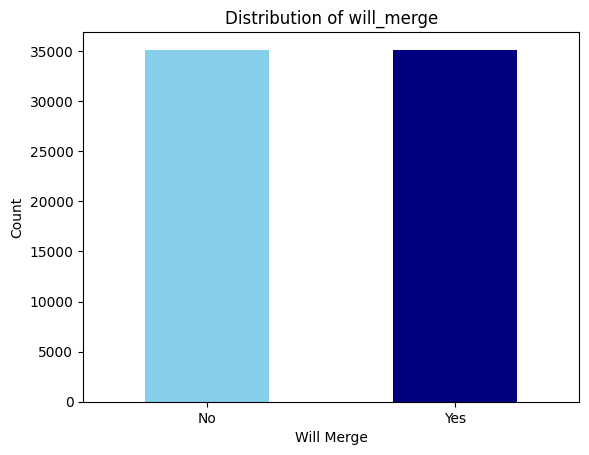

In [8]:
# Check the distribution of will merge
data['will_merge'].value_counts().plot(kind='bar', color=['skyblue', 'navy'])
plt.title('Distribution of will_merge')
plt.xlabel('Will Merge')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()

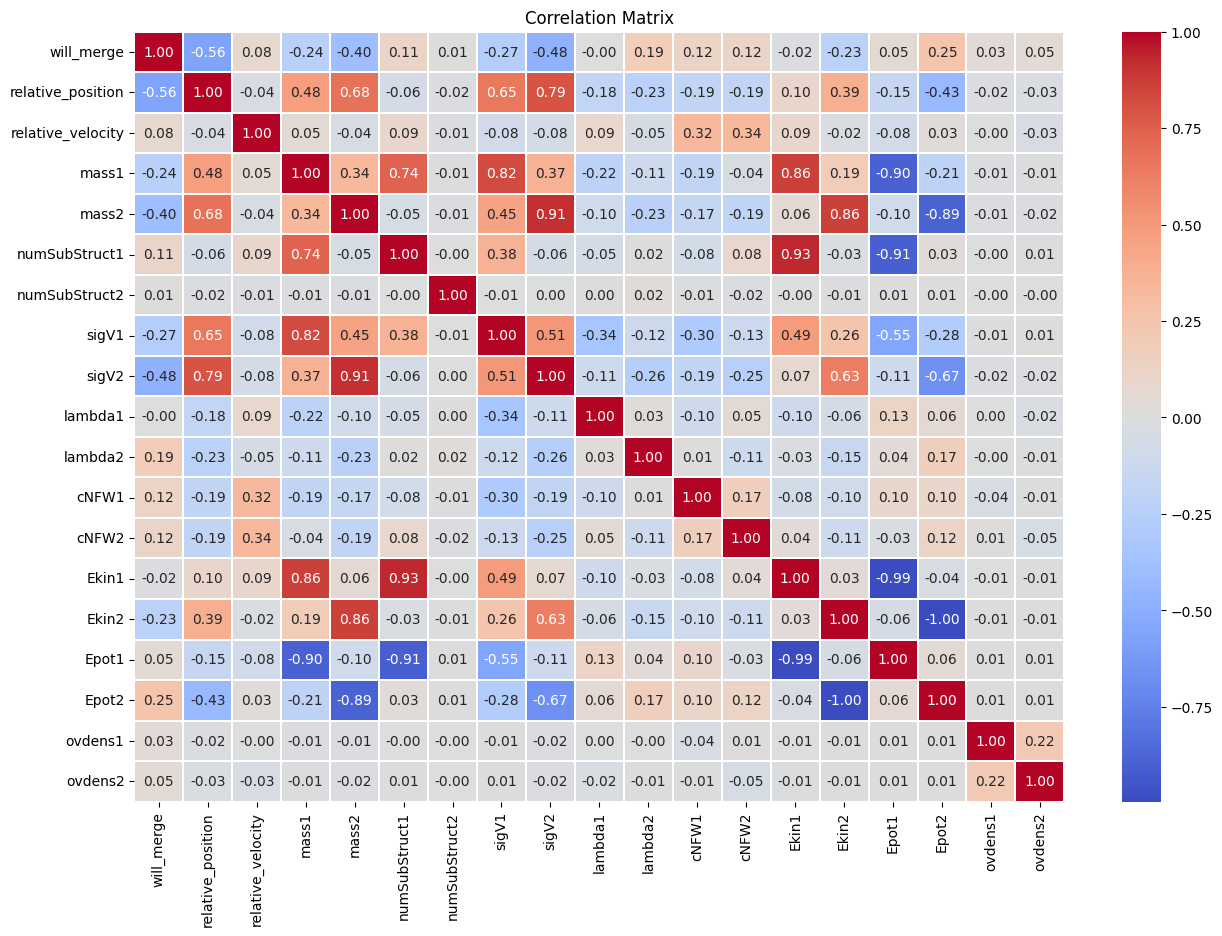

In [9]:
corr_matrix = data.drop(columns='pair').corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.3)
plt.title('Correlation Matrix')
plt.show()

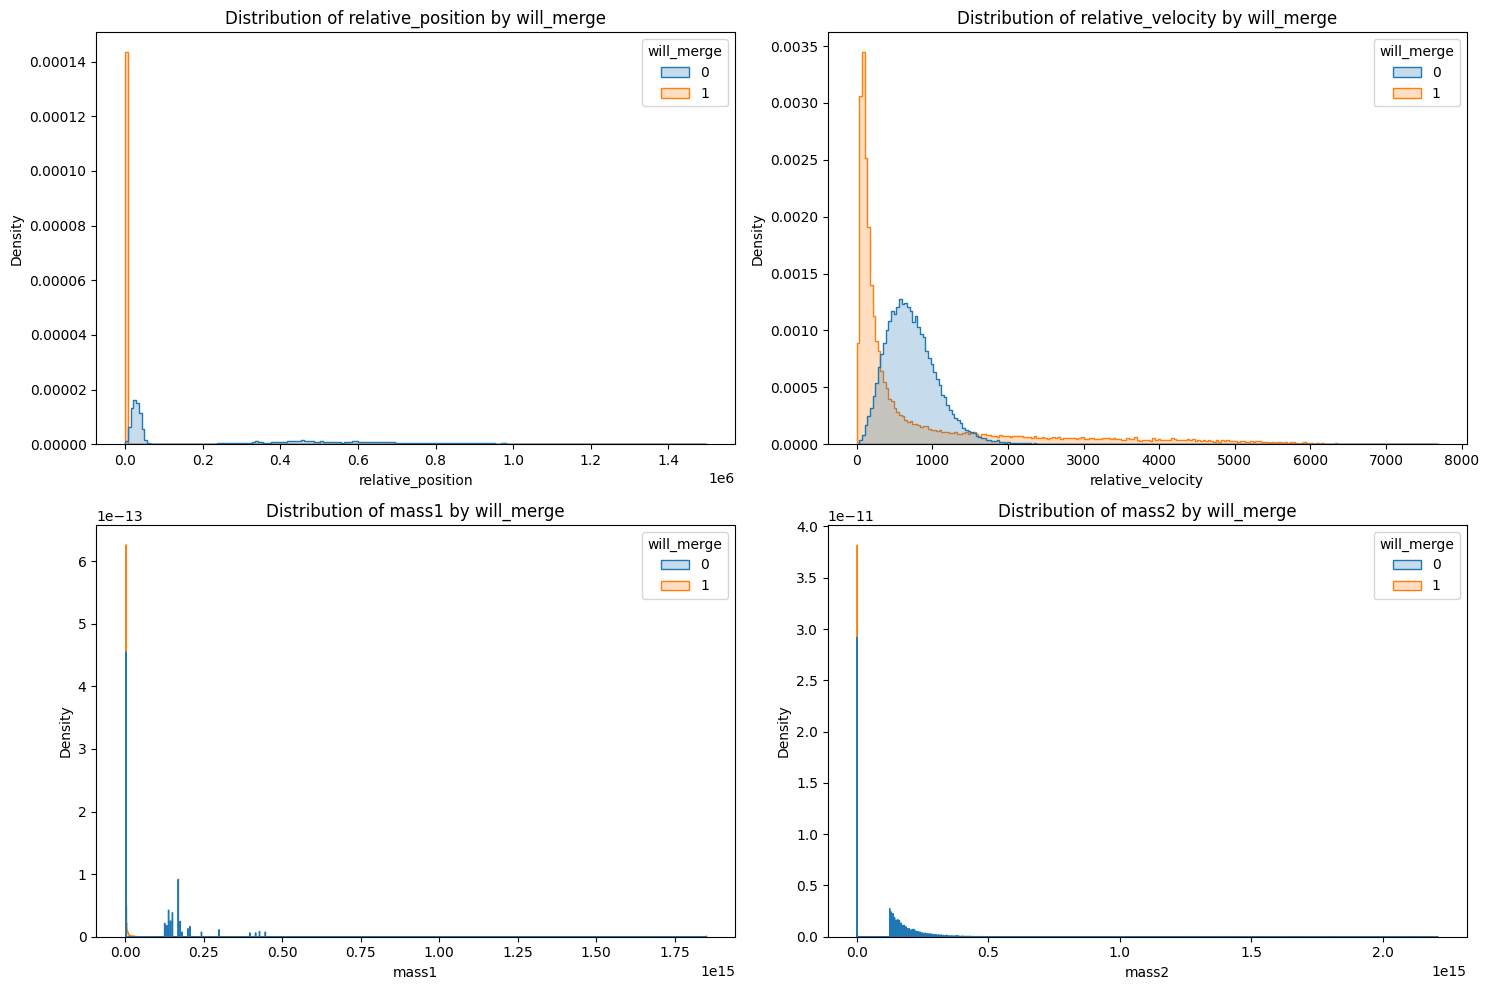

In [10]:
features = ['relative_position', 'relative_velocity', 'mass1', 'mass2']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, feature in zip(axs.flatten(), features):
    sns.histplot(data, x=feature, hue='will_merge', element='step', stat='density', common_norm=False, ax=ax)
    ax.set_title(f'Distribution of {feature} by will_merge')

plt.tight_layout()
plt.show()

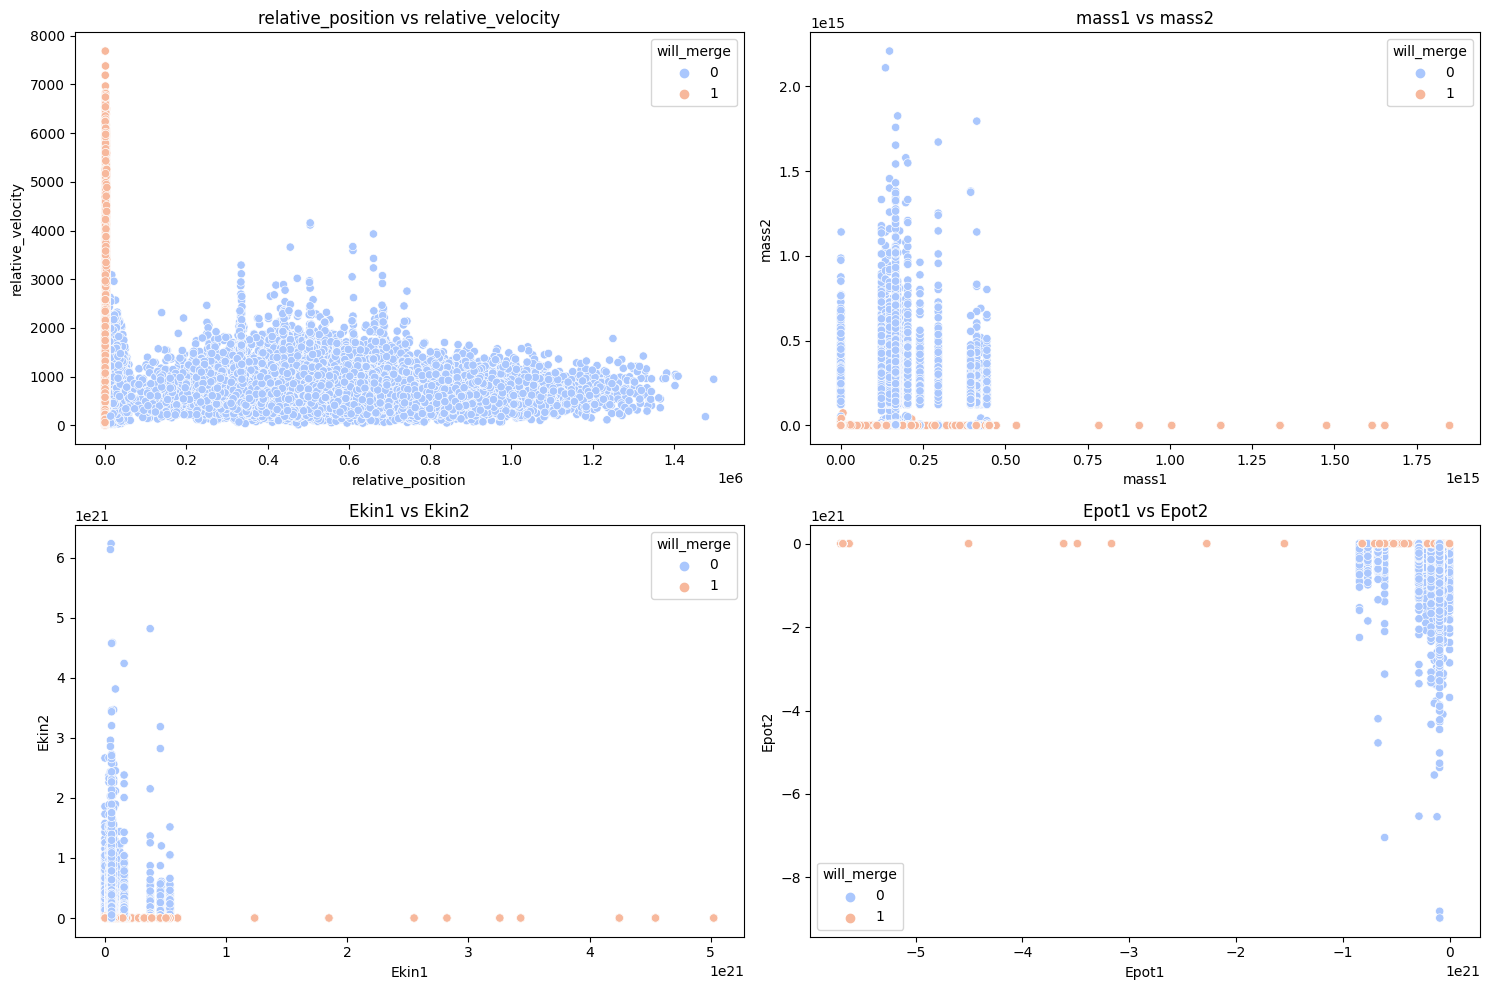

In [11]:
feature_pairs = [('relative_position', 'relative_velocity'), 
                 ('mass1', 'mass2'), 
                 ('Ekin1', 'Ekin2'), 
                 ('Epot1', 'Epot2')]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, (feature1, feature2) in zip(axs.flatten(), feature_pairs):
    sns.scatterplot(data=data, x=feature1, y=feature2, hue='will_merge', palette='coolwarm', ax=ax)
    ax.set_title(f'{feature1} vs {feature2}')

plt.tight_layout()
plt.show()